In [1]:
using Pkg
Pkg.activate("../QControl")

  Activating project at `~/Github/mit/QControl.jl/QControl`


# Imports

In [2]:
import QControl

In [3]:
QControl.greet()

Hello World wow!

In [4]:
using QuantumOptics
using PyPlot
using Altro
using ForwardDiff
using LinearAlgebra
using SparseArrays
using RobotDynamics
using TrajectoryOptimization
using StaticArrays
using ForwardDiff
using FiniteDiff
const TO = TrajectoryOptimization
const RD = RobotDynamics

RobotDynamics

# Optimal Control with Altro

In [5]:
RobotDynamics.@autodiff struct QuantumState <: RobotDynamics.ContinuousDynamics end
# TODO: store appropriate information in QuantumState, e.g. state size

function complex_to_real_isomorphism(M::Union{Matrix,SparseMatrixCSC}) #TODO Union{Matrix{ComplexF64}, SparseMatrixCSC{ComplexF64, Int64}})
    """
    M
    => 
    Mᵣ -Mᵢ
    Mᵢ  Mᵣ
    """
    return [real(M) -imag(M); imag(M) real(M)]
end 

function real_to_complex_isomorphism(M_full::Union{Matrix,SparseMatrixCSC}) #TODO: {Float64})
    """
    Mᵣ -Mᵢ
    Mᵢ  Mᵣ
    => 
    M
    """
    n_rows, n_cols = size(M_full)
    M = M_full[1:n_rows ÷ 2,1:n_cols ÷ 2] + im*M_full[n_rows ÷ 2+1:end, 1:n_cols ÷ 2]
    return M
end 

function im_times_isomorphism(M_full::Union{Matrix,SparseMatrixCSC}) #TODO: {Float64})
    """
    i(Mᵣ + iMᵢ) -> -Mᵢ + iMᵣ
    

    im
    *
     Mᵣ -Mᵢ
     Mᵢ  Mᵣ
    => 
    -Mᵢ -Mᵣ
     Mᵣ -Mᵢ   
    """
    n_rows_full, n_cols_full = size(M_full)
    n_rows = n_rows_full ÷ 2
    n_cols = n_cols_full ÷ 2
    Mᵣ = M_full[1:n_rows,1:n_cols]
    Mᵢ = M_full[n_rows+1:end, 1:n_cols]
    return [-Mᵢ -Mᵣ; Mᵣ -Mᵢ]
end

function conj_isomorphism(M_full::Union{Matrix,SparseMatrixCSC}) #TODO: {Float64})
    """
    Mᵣ + iMᵢ -> Mᵣ + i (-Mᵢ)
    
    
     Mᵣ -Mᵢ
     Mᵢ  Mᵣ
    => 
     Mᵣ  Mᵢ
    -Mᵢ  Mᵣ 
    """
    n_rows_full, n_cols_full = size(M_full)
    n_rows = n_rows_full ÷ 2
    n_cols = n_cols_full ÷ 2
    Mᵣ = M_full[1:n_rows,1:n_cols]
    Mᵢ = M_full[n_rows+1:end, 1:n_cols]
    
    return [Mᵣ Mᵢ; -Mᵢ Mᵣ]
end
    
function complex_to_real_isomorphism(v::Vector) #TODO: {ComplexF64})
    """
    v
    => 
    vᵣ
    vᵢ
    """
    return [real(v); imag(v)]
end 

function real_to_complex_isomorphism(v_full::Vector) #TODO: {Float64})
    """
    vᵣ
    vᵢ
    => 
    v
    """
    n_rows = size(v_full)[1]
    v = v_full[1:n_rows ÷ 2] + im*v_full[n_rows ÷ 2 + 1: end]
    return v
end 

function im_times_isomorphism(v_full::Vector) #TODO:{Float64})
    """
    i(vᵣ + ivᵢ) -> -vᵢ + ivᵣ
    
    im 
    *
     vᵣ
     vᵢ
    => 
    -vᵢ
     vᵣ
    """
    n_rows_full = size(v_full)[1]
    n_rows = n_rows_full ÷ 2
    vᵣ = v_full[1:n_rows]
    vᵢ = v_full[n_rows + 1: end]
    return [-vᵢ ; vᵣ]
end 

function conj_isomorphism(v_full::Vector) # TODO: {Float64})
    """
    vᵣ + ivᵢ -> vᵣ + i(-vᵢ)
    
     vᵣ
     vᵢ
    => 
     vᵣ
    -vᵢ
    """
    n_rows_full = size(v_full)[1]
    n_rows = n_rows_full ÷ 2
    vᵣ = v_full[1:n_rows]
    vᵢ = v_full[n_rows + 1: end]
    return [vᵣ ; -vᵢ]
end

function gen_LQR_params(bfull::Basis, H₀::Operator, Hcs::Vector{<:Operator}, ψi::Vector{<:Ket}, ψt::Vector{<:Ket})
    """
    
    Args:
        bfull: full basis
        H₀ (Operator)
        Hcs (Vector{Ket}): vector of control Hamiltonians 
        ψi (Vector): vector of initial states
        ψt (Vector): vector of target states
    """
    H₀_full = complex_to_real_isomorphism(H₀.data)
    Hcs_full = complex_to_real_isomorphism.(map(H -> H.data, Hcs))
    ψi_full = complex_to_real_isomorphism.(map(ψ -> ψ.data, ψi))
    ψt_full = complex_to_real_isomorphism.(map(ψ -> ψ.data, ψt))
     
    
    ψi_combined = reduce(vcat, ψi_full)
    ψt_combined = reduce(vcat, ψt_full)
    
    num_states = size(ψi_full)[1]
    state_size = size(ψi_full[1])[1]
    @assert size(ψi_full)[1] == size(ψt_full)[1]
    state_dim = num_states*state_size
    
    num_controls = size(Hcs_full)[1] 
    control_dim = 2*num_controls # Factor of 2 comes from complex -> real
    
    
    function dynamics_func(::QuantumState, x, u)
        ψ_full = map(i -> x[(i-1)*state_size + 1:i*state_size], 1:num_states)
        Ht_full = H₀_full
        for control_indx=1:num_controls
            uᵣ = u[control_indx]
            uᵢ = u[control_indx + num_controls]
            Ht_full += uᵣ*Hcs_full[control_indx] + uᵢ*im_times_isomorphism(Hcs_full[control_indx])
        end
        
        # TODO: density matrices, loss, etc
        dψ = reduce(vcat, map(i -> - im_times_isomorphism(Ht_full*ψ_full[i]), 1:num_states))
        return dψ
    end
    
    
    return state_dim, control_dim, dynamics_func, ψi_combined, ψt_combined
end

;

# Single Qubit System

In [6]:
bq_single = SpinBasis(1//2)
H₀_single = 2*π*5*sigmaz(bq_single)/2
Hcs_single = [sigmax(bq_single)/2]
ψi_single = [spinup(bq_single)]
ψt_single = [spindown(bq_single)]
;

In [7]:
RD.state_dim(::QuantumState), RD.control_dim(::QuantumState), dynamics_func, ψi_state, ψt_state = gen_LQR_params(bq_single, H₀_single, Hcs_single, ψi_single, ψt_single)
RD.dynamics(qs::QuantumState,x,u) = dynamics_func(qs::QuantumState,x,u)
;

In [28]:
model = QuantumState()
state_dim = RD.state_dim(model)
control_dim = RD.control_dim(model)

N = 1001 # number of time steps
tf = 3.0 # ns, total time
dt = tf / (N-1) # time step

# n_op = sigmap(bq_single)*sigmam(bq_single)
# Q = complex_to_real_isomorphism(n_op.data)
# Q = complex_to_real_isomorphism(one(bq_single).data)
Q = complex_to_real_isomorphism([0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im])

# R = complex_to_real_isomorphism(reshape([1.0 + 0.0*im],(1,1)))
R = complex_to_real_isomorphism(reshape([0.0001 + 0.0*im],(1,1)))

I_matrix = complex_to_real_isomorphism(one(bq_single).data .+ 0*im)
Qf = (I_matrix - ψt_state*transpose(conj_isomorphism(ψt_state)))
# ⟨ψf|Qf|ψf⟩ = ⟨ψf|(I - |ψt⟩⟨ψt|)|ψf⟩ = 1 - |⟨ψf|ψt⟩|^2

obj = LQRObjective(Q,R,Qf,ψt_state,N)

Objective

In [29]:
prob = Problem(model, obj, ψi_state, tf, xf=ψt_state, integration=RD.RK4(model)) # constraints=cons,
;

In [30]:
initial_controls!(prob, [@SVector rand(control_dim) for k = 1:N-1])
rollout!(prob)   # simulate the system forward in time with the new controls

In [31]:
# Set up solver options
opts = SolverOptions()
opts.cost_tolerance = 1e-5

# Create a solver, adding in additional options
solver = ALTROSolver(prob, opts, show_summary=false)
;

In [32]:
solve!(solver);

In [33]:
status(solver)

SOLVE_SUCCEEDED::TerminationStatus = 2

In [34]:
println("Number of iterations: ", iterations(solver))
println("Final cost: ", cost(solver))
println("Final constraint satisfaction: ", max_violation(solver)) #TODO: is 1 good??

Number of iterations: 12
Final cost: 0.07307638213892492
Final constraint satisfaction: 1.0


In [73]:
X = states(solver)     # alternatively states(prob)
U = controls(solver)   # alternatively controls(prob)
Xv = Vector.(X)
Uv = Vector.(U)
Xcv = real_to_complex_isomorphism.(Xv)
Ucv = real_to_complex_isomorphism.(Uv)
Urv = map(cv -> real(cv)[1], Ucv)
Uiv = map(cv -> imag(cv)[1], Ucv)
Xqv = map(cv -> normalize(Ket(bq_single, cv)), Xcv)
;

In [47]:
println(Xqv[1])
println(Xqv[end])

Ket(dim=2)
  basis: Spin(1/2)
 1.0 + 0.0im
 0.0 + 0.0im
Ket(dim=2)
  basis: Spin(1/2)
 -0.08370115831603145 - 0.00032251689249367im
   0.9964908476785347 + 5.071808680825e-5im


In [69]:
szt = map(qv -> real(expect(sigmaz(bq_single),qv)), Xqv);

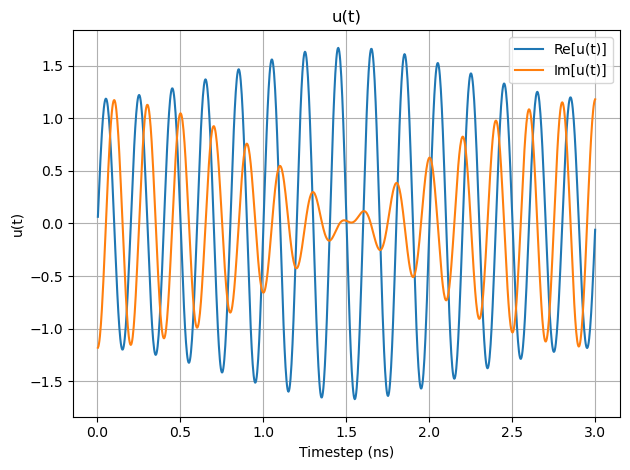

In [78]:
ts = 1:N-1
xlabel("Timestep (ns)")
ylabel("u(t)")
title("u(t)")
plot(dt*ts, Urv, label="Re[u(t)]")
plot(dt*ts, Uiv, label="Im[u(t)]")
grid("on")
legend()
tight_layout()

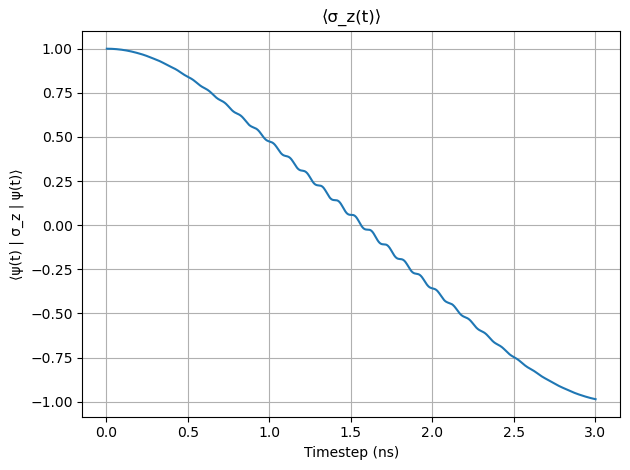

In [77]:
ts = 1:N
plot(dt*ts, szt)
xlabel("Timestep (ns)")
ylabel("⟨ψ(t) | σ_z | ψ(t)⟩")
title("⟨σ_z(t)⟩")
grid("on")
tight_layout()

# Cavity-Qubit System Setup

In [120]:
# Define bases for cavity (Fock) and atom (Spin-1/2)
const N_CAVITY = 10
const N_QUBIT = 2

bq = SpinBasis(1//2)
bc = FockBasis(N_CAVITY - 1)
bfull = bc ⊗ bq
DAC_time_resolution = 1 # ns


# constants (in GHz = cycles / ns)
α = .4
K = 1e-5
χ = 2e-3
D = 1e-3

# operators
a = destroy(bc) ⊗ one(bq)
σ⁻ = one(bc) ⊗ sigmam(bq) # up -> down, equivalent to creation op
ad = dagger(a)
σ⁺ = dagger(σ⁻)

# base hamiltonian
H₀ = (α/2) * σ⁻ * σ⁻ * σ⁺ * σ⁺
H₀ += (K/2) * ad * ad * a * a
H₀ += χ * ad * a * σ⁻ * σ⁺
H₀ *= 2*π
Hcs = [2*π*D*(σ⁺ + σ⁻), im*2*π*D*(σ⁺ + σ⁻), 2*π*D*(a+ad), im*2*π*(a - ad)];

# binomial code
binomial = Dict("z+" => normalize(fockstate(bc,0) + fockstate(bc,4)), "z-" => fockstate(bc, 2))

# states
ψi = [fockstate(bc, 0) ⊗ spinup(bq)]
ψt = [binomial["z+"] ⊗ spinup(bq)]

;

In [121]:
RD.state_dim(::QuantumState), RD.control_dim(::QuantumState), dynamics_func = gen_LQR_params(bfull, H₀, Hcs, ψi, ψt)
RD.dynamics(qs::QuantumState,x,u) = dynamics_func(qs::QuantumState,x,u)
;

In [123]:
# @assert 0.0 == maximum(abs.(ψi[1].data - real_to_complex_isomorphism(complex_to_real_isomorphism(ψi[1].data))))
# @assert 0.0 == maximum(abs.(H₀.data - real_to_complex_isomorphism(complex_to_real_isomorphism(H₀.data))))

# Playground

In [ ]:
# Construct Hamiltonian
ψ₀ = fockstate(bc,0) ⊗ spinup(bq)
T = [0.0:0.01:1;];

In [ ]:
tout, ψₜ = timeevolution.schroedinger(T, ψ₀, H) ;

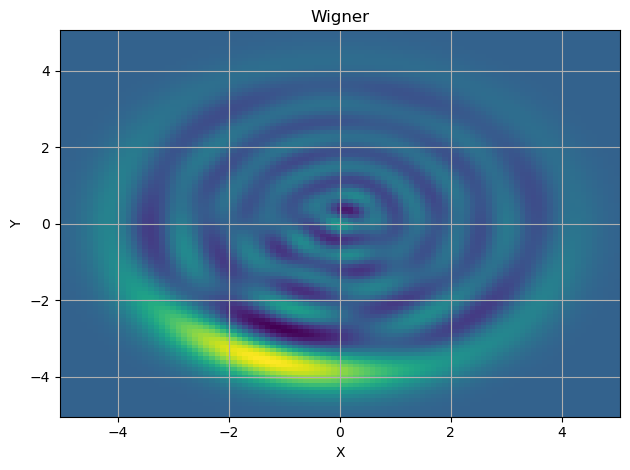

In [ ]:
x = [-5:0.1:5;]
W = wigner(ptrace(ψ₁,2), x, x)
pcolor(x,x,W)
xlabel("X")
ylabel("Y")
title("Wigner")
grid("on")
tight_layout()

# References

[1] https://arxiv.org/pdf/1707.01060.pdf (quantum optics)

[2] https://github.com/alec-eickbusch/QOGS (quantum optimal gate synthesis)

[3] https://arxiv.org/pdf/2103.15716.pdf  (robotic quantum optimal control)

[4] https://journals.aps.org/prx/pdf/10.1103/PhysRevX.6.031006 (binomial code)